In [34]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import mplfinance as mpf
import matplotlib.dates as mpl_dates
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import linregress

import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds

In [4]:
# Implement ATR 


In [5]:
xlf_df =pd.read_csv("./data/XLF.csv", index_col='Date', parse_dates=True)
xlf_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-05,28.480000,28.480000,28.230000,28.410000,25.635395,37989500
2018-01-08,28.379999,28.430000,28.270000,28.370001,25.599300,44252100
2018-01-09,28.490000,28.740000,28.440001,28.590000,25.797815,51418700
2018-01-10,28.680000,28.950001,28.629999,28.830000,26.014380,64670900
2018-01-11,28.950001,29.000000,28.809999,28.969999,26.140703,42361700


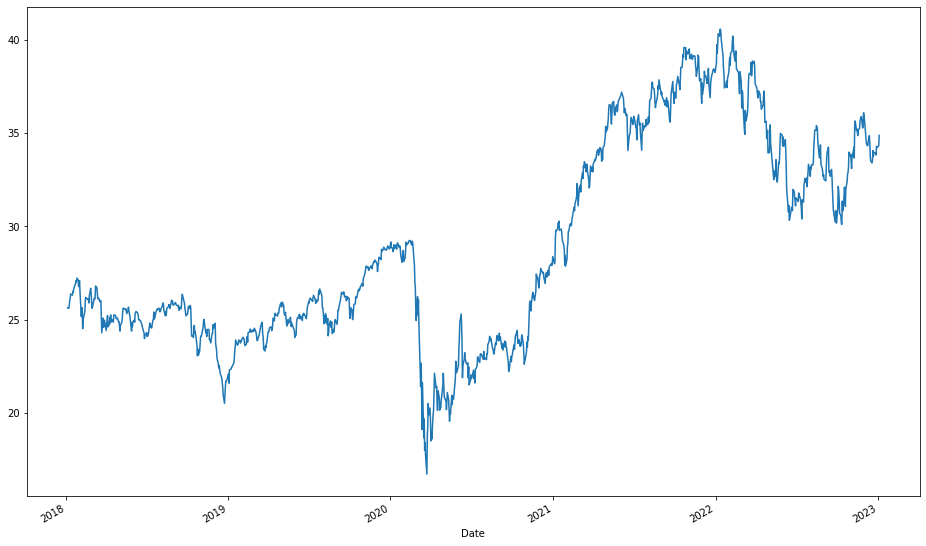

In [6]:
xlf_df['Adj Close'].plot(figsize=(16,10))

In [7]:
# Calculate the ATR
xlf_df['High_Low'] = xlf_df['High'] - xlf_df['Low']
xlf_df['High_Close'] = xlf_df['High'] - xlf_df['Close'].shift(1)
xlf_df['Low_Close'] = xlf_df['Low'] - xlf_df['Close'].shift(1)

xlf_df.dropna(inplace=True)
xlf_df.head()

,Open,High,Low,Close,Adj Close,Volume,High_Low,High_Close,Low_Close
Date,,,,,,,,,
2018-01-08,28.379999,28.430000,28.270000,28.370001,25.599300,44252100,0.160000,0.020000,-0.140000
2018-01-09,28.490000,28.740000,28.440001,28.590000,25.797815,51418700,0.299999,0.369999,0.070000
2018-01-10,28.680000,28.950001,28.629999,28.830000,26.014380,64670900,0.320002,0.360001,0.039999
2018-01-11,28.950001,29.000000,28.809999,28.969999,26.140703,42361700,0.190001,0.170000,-0.020001
2018-01-12,29.139999,29.250000,28.959999,29.230000,26.375311,44537500,0.290001,0.280001,-0.010000


In [8]:
xlf_df['True_Ranges'] = pd.DataFrame(np.max(xlf_df[['High_Low','High_Close','Low_Close']],axis=1))
xlf_df['True_Ranges']

Date
2018-01-08    0.160000
2018-01-09    0.369999
2018-01-10    0.360001
2018-01-11    0.190001
2018-01-12    0.290001
                ...   
2022-12-28    0.310001
2022-12-29    0.529998
2022-12-30    0.350002
2023-01-03    0.619999
2023-01-04    0.799999
Name: True_Ranges, Length: 1257, dtype: float64

In [9]:
xlf_df['Average_True_Range'] = xlf_df['True_Ranges'].rolling(14).mean()
xlf_df.tail()

,Open,High,Low,Close,Adj Close,Volume,High_Low,High_Close,Low_Close,True_Ranges,Average_True_Range
Date,,,,,,,,,,,
2022-12-28,34.000000,34.090000,33.779999,33.820000,33.820000,24395100,0.310001,0.150001,-0.160000,0.310001,0.524286
2022-12-29,34.000000,34.349998,33.919998,34.290001,34.290001,26624200,0.430000,0.529998,0.099998,0.529998,0.536429
2022-12-30,34.040001,34.270000,33.919998,34.200001,34.200001,24725300,0.350002,-0.020001,-0.370003,0.350002,0.540000
2023-01-03,34.450001,34.689999,34.070000,34.320000,34.320000,37396500,0.619999,0.489998,-0.130001,0.619999,0.538572
2023-01-04,34.669998,35.119999,34.570000,34.869999,34.869999,44669300,0.549999,0.799999,0.250000,0.799999,0.520714


/Users/dennismacpro/miniconda3/lib/python3.7/site-packages/mplfinance/_arg_validators.py:93: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)


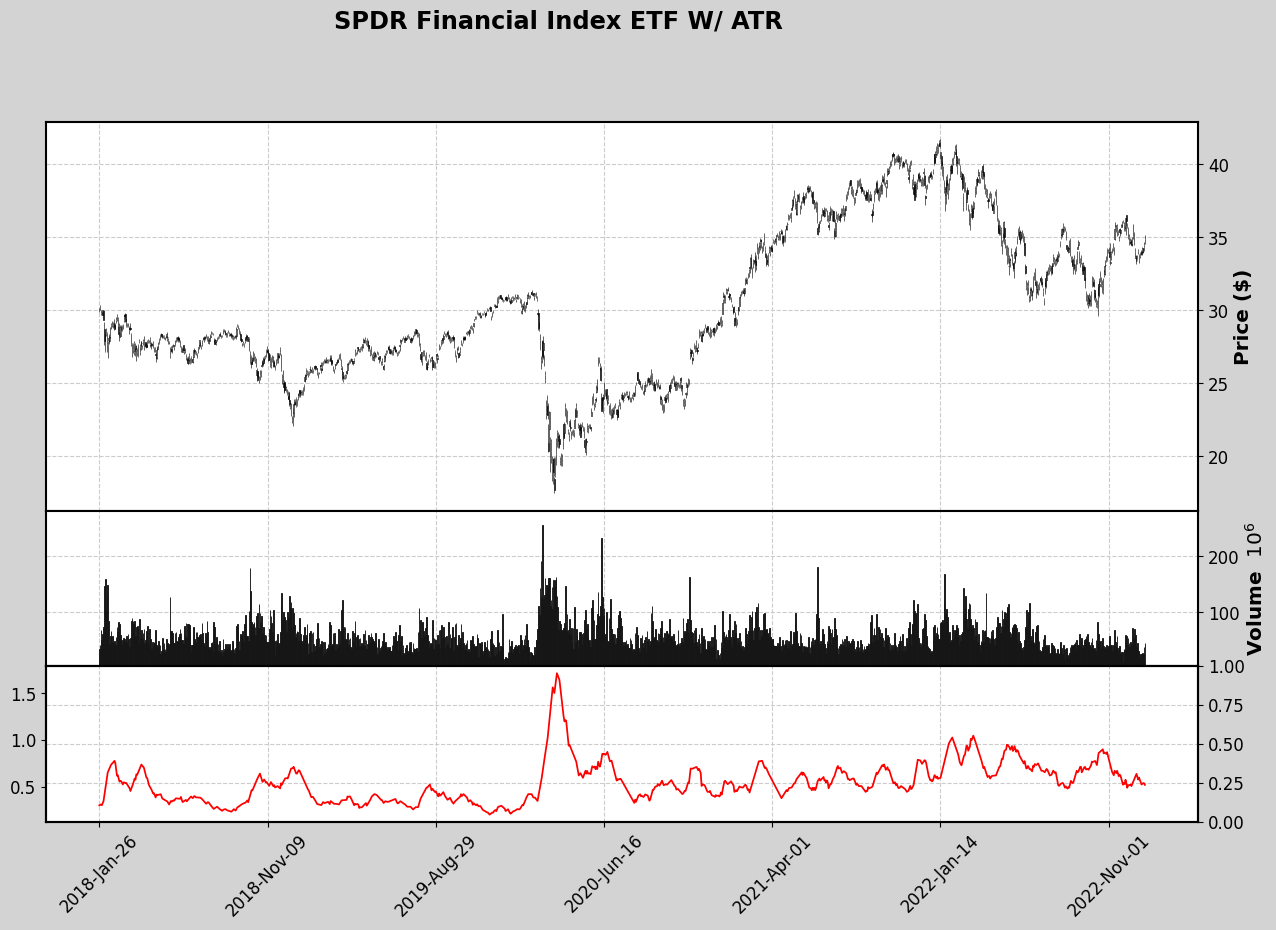

In [10]:
xlf_df.dropna(inplace=True)



apd = [
        # ATR
        mpf.make_addplot(xlf_df['Average_True_Range'], panel=2,secondary_y=True, color='red'),
]

mpf.plot(xlf_df[['Open','High','Low','Close','Volume']], 
         type='candle', 
         title='SPDR Financial Index ETF W/ ATR', 
         style=mpf.make_mpf_style(base_mpf_style='classic',rc={'figure.facecolor':'lightgray'}),
         ylabel='Price ($)',
         volume=True, 
         addplot=apd,
         figsize=(16,10));

In [25]:
# Momentum Based Indicator
def download_stocks(stocks, start,end):
    data = {}
    for stock in stocks:
        ticker = yf.download(stock, start, end)
        data[stock] = ticker['Adj Close']
    return pd.DataFrame(data)

def calculate_momentum(data):
    log_data = np.log(data)
    x_data = np.arange(len(log_data))
    # beta is the slope, multiple by accurancy of model rvalue
    beta, _, rvalue, _, _ = linregress(x_data, log_data)
    # we have to annualize the slope (252 trading days in a year)
    return (1+beta) ** 252 * (rvalue**2)

In [26]:
start_date = datetime(2015,1,1)
end_date = datetime(2018,1,1)
stocks = ['IBM','TSLA','MSFT','AAPL','XOM','CVX','INTC']
momentums = pd.DataFrame(columns=stocks)

In [17]:
stocks_data = download_stocks(stocks,start_date,end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [27]:
for stock in stocks:
    momentums[stock] = stocks_data[stock].rolling(90).apply(calculate_momentum,raw=False)

In [28]:
momentums.dropna()

,IBM,TSLA,MSFT,AAPL,XOM,CVX,INTC
Date,,,,,,,
2015-05-12,0.908568,0.178883,0.001991,0.894138,0.254870,0.072690,0.343139
2015-05-13,0.964880,0.242525,0.009468,0.849822,0.239005,0.099240,0.330011
2015-05-14,1.003109,0.294381,0.023685,0.814507,0.229908,0.107123,0.314131
2015-05-15,1.020230,0.355490,0.040533,0.778328,0.220672,0.117888,0.299925
2015-05-18,1.031736,0.419460,0.063322,0.750014,0.210177,0.121531,0.278477
...,...,...,...,...,...,...,...
2017-12-22,0.969869,0.301651,1.579725,0.812011,0.926312,0.889369,2.222690
2017-12-26,0.950091,0.302831,1.575785,0.814120,0.915567,0.889017,2.207897
2017-12-27,0.929007,0.307456,1.572503,0.813499,0.904181,0.888165,2.186795


In [29]:
bests = momentums.max().sort_values(ascending=False).index[:5]
bests

Index(['TSLA', 'MSFT', 'AAPL', 'INTC', 'CVX'], dtype='object')

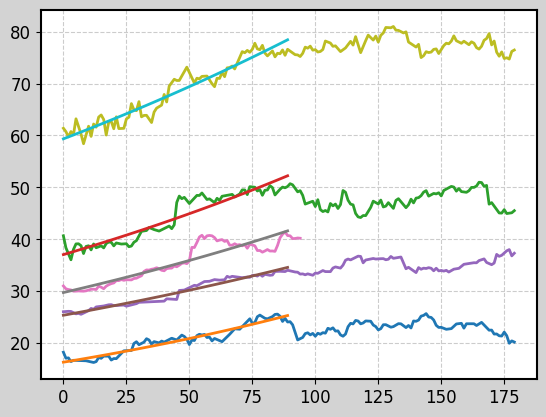

In [33]:
for best in bests:
    end = momentums[best].index.get_loc(momentums[best].idxmax())
    returns = np.log(stocks_data[best].iloc[end - 90: end])
    x = np.arange(len(returns))
    slope, intercept, r_value, p_value, std_err = linregress(x, returns)
    plt.plot(np.arange(len(stocks_data[best][end - 90: end + 90])), stocks_data[best][end-90: end+ 90])
    plt.plot(x, np.e ** (intercept + slope * x))
    

In [37]:
# Implement Strategy
# https://www.backtrader.com/recipes/indicators/mfi/mfi/
# https://www.backtrader.com/docu/inddev/


In [63]:
class Momentum(bt.Indicator):
    # every trading day has a momentum parameter
    # except for the first 90 days 
    lines = ("momentum_trend",)
    params = (('period',90),)
    
    def __init__(self):
        self.addminperiod(self.params.period)
        
    def next(self):
        returns = np.log(self.data.get(size=self.params.period))
        x = np.arange(len(returns))
        beta, _, rvalue, _, _ = linregress(x, returns)
        annualized = (1+beta) ** 252
        self.lines.momentum_trend[0] = annualized * rvalue ** 2

In [76]:
class MomentumStrategy(bt.Strategy):
    """
    * trade once in a week and update the portfolio once in every second week
    * open trades when the ^ES is above its SMA 200
    * rank the stonck in the ^ES index based on momentum based on past 90 days
    * buy stocks that are in the top 20% momentum range
    * sell stocks that ar enot in the top 20% momentum range or their prices have fallen below their SMA

    -> https://www.backtrader.com/docu/strategy/
    
    """
    
    def __init__(self):
        self.number_of_days_ellapsed = 0
        self.indicators = {}
        self.sorted_data = []
        # we store the ^ES! data as the first item of the dataset
        self.spy = self.datas[0]
        # all the other stocks
        self.stocks = self.datas[1:]
        
        for stock in self.stocks:
            self.indicators[stock] = {}
            self.indicators[stock]['momentum'] = Momentum(stock.close, period=90)
            self.indicators[stock]['sma100'] = bt.indicators.SimpleMovingAverage(stock.close, period=100)
            self.indicators[stock]['atr20'] = bt.indicators.ATR()
            
        # SMA for ^ES Index - bc we open long position when the index its above SMA
        self.sma200 = bt.indicators.SimpleMovingAverage(self.spy.close, period=200)
        
    def prenext(self):
        # count the number of days elapsed, strategy awaits 5 days
        self.next()
    
    def next(self):
        # a week has passed so we have to make trades if needed
        if self.number_of_days_ellapsed % 5 == 0:
            self.rebalance_portfolio()
        if self.number_of_days_ellapsed % 10 == 0:
            self.update_positions()
            
        self.number_of_days_ellapsed +=1
        
    
    def rebalance_portfolio(self):
        self.sorted_data = list(filter(lambda stock_data: len(stock_data) > 100, self.stocks))
        # sort the SP500 stocks based on momentum
        self.sorted_data.sort(key=lambda stock: self.indicators[stock]['momentum'][0])
        number_stocks = len(self.sorted_data)
        
        # sell stocks or close the close the long position - top 20%
        for index, single_stock in enumerate(self.sorted_data):
            # we can check whether they are open position or not
            if self.getposition(self.data).size:
                # if the stock is not in the top 20% then we have to close the long position
                # if the stock price falls below its 100 day sma
                if index > (0.2 * number_stocks) or single_stock < self.indicators[single_stock]['sma100']:
                    self.close(single_stock)
        
        # open long position when the sma is below the index
        if self.spy < self.sma200:
            return
        
        # consider top 20% of stocks and buy accordingly
        for index, single_stock in enumerate(self.sorted_data[:int(0.2 * number_stocks)]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash > 0 and not self.getposition(self.data).size:
                size = value * 0.001 / self.indicators[single_stock]["atr20"]
                self.buy(single_stock, size=size)
    
    def update_positions(self):
        number_stocks = len(self.sorted_data)
        
        # top 20% momentum range
        for index, single_stock in enumerate(self.sorted_data[:int(0.2*number_stocks)]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash > 0:
                size = value * 0.001 / self.indicators[single_stock]["atr20"]
                self.order_target_size(single_stock,size)              

In [77]:
stocks = []
cerebro = bt.Cerebro()

In [86]:
with open('./momentum_strategy_data/companies_all') as company_file:
    for line in company_file:
        stocks.append(line.strip("\n"))
        try:
            df = pd.read_csv("./momentum_strategy_data/"+line.strip('\n'),parse_dates=True,index_col=0)
            if len(df) > 100:
                cerebro.adddata(bt.feeds.PandasData(dataname=df,plot=False))
        except FileNotFoundError:
            pass

cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.25)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(MomentumStrategy)

cerebro.broker.set_cash(100000)

# commission fee is 0.5 %
cerebro.broker.setcommission(0.005)



In [87]:
print("Initial Capital: $%.2f" % cerebro.broker.get_value())

Initial Capital: $100000.00


In [88]:
results = cerebro.run()

In [89]:
print(f"Sharpe:{results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max drawdown:{results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}")
print("Capital: $%.2f" % cerebro.broker.getvalue())

Sharpe:-1.667
Norm. Annual Return: -inf%
Max drawdown:863.84
Capital: $-1289804.30
